# Import Modules

Code from rhammell's kaggke workbook & dataset: https://www.kaggle.com/paultimothymooney/identifying-ships-in-satellite-images

In [2]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image 
import json  
import mpl_toolkits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from PIL import Image
import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import model_selection
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import callbacks
from keras.utils.vis_utils import plot_model
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
80*80*3*2800

53760000

In [3]:
with open('shipsnet/shipsnet.json') as data_file:
    dataset = json.load(data_file)
Shipsnet= pd.DataFrame(dataset)
print(Shipsnet.head())
print('')    
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of NoShip Images: {}'.format(np.sum(b==0)))
    print('Number of Ship Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(x,y)

                                                data  labels  \
0  [41, 40, 41, 44, 43, 40, 38, 40, 44, 42, 31, 3...       1   
1  [22, 19, 26, 26, 21, 20, 26, 24, 24, 28, 20, 1...       1   
2  [112, 112, 106, 104, 107, 109, 113, 115, 108, ...       1   
3  [72, 76, 73, 72, 73, 74, 75, 73, 74, 73, 73, 7...       1   
4  [63, 58, 58, 63, 65, 66, 70, 66, 59, 67, 71, 6...       1   

                                  locations             scene_ids  
0  [-122.34270462076896, 37.75058641760489]  20170501_180618_1005  
1  [-122.34975593269652, 37.76979644106731]  20170501_181320_0e1f  
2  [-122.34908354683306, 37.74935096766827]  20170609_180756_103a  
3  [-122.32613080820607, 37.73816285249999]  20170721_180825_100b  
4  [-122.3332290637038, 37.721168346437786]  20170702_180943_103c  

Total number of images: 2800
Number of NoShip Images: 2100
Number of Ship Images: 700
Percentage of positive images: 25.00%
Image shape (Width, Height, Channels): (19200,)


In [4]:
xReshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
yReshaped = to_categorical(y, num_classes=2)
print("Data Shape",x.shape)
print('Labels Shape',y.shape)
print('Reshaped Data Shape',xReshaped.shape)
print('Reshaped Labels Shape',yReshaped.shape)
def describeDataset(features,labels):
    print("\n'X' shape: %s."%(features.shape,))
    print("\n'y' shape: %s."%(labels.shape,))
    print("\nUnique elements in y: %s"%(np.unique(y)))
describeDataset(xReshaped,yReshaped)

Data Shape (2800, 19200)
Labels Shape (2800,)
Reshaped Data Shape (2800, 80, 80, 3)
Reshaped Labels Shape (2800, 2)

'X' shape: (2800, 80, 80, 3).

'y' shape: (2800, 2).

Unique elements in y: [0 1]


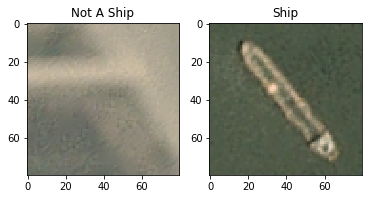

In [5]:
imgs0 = xReshaped[y==0] 
imgs1 = xReshaped[y==1] 

def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('Not A Ship')
    plt.imshow(a[104])
    plt.subplot(1,2,2)
    plt.title('Ship')
    plt.imshow(b[101])
plotOne(imgs0, imgs1) 

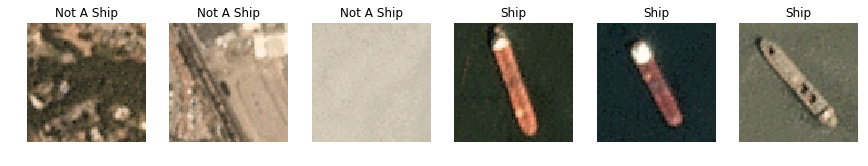

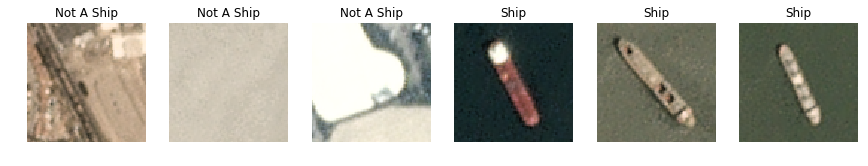

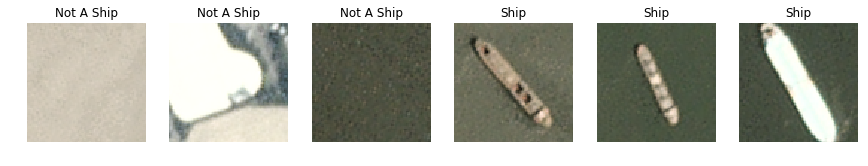

In [6]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('Not A Ship')
            plt.imshow(a[row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('Ship')
            plt.imshow(b[row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1) 

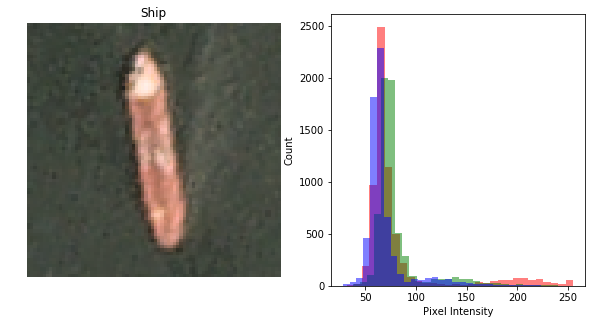

In [7]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('Ship' if y[1] else 'Not A Ship')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(xReshaped[100])

In [13]:
xReshaped[100]

array([[[0.25490196, 0.27843137, 0.24705882],
        [0.23137255, 0.25098039, 0.22352941],
        [0.19607843, 0.21960784, 0.19215686],
        ...,
        [0.27058824, 0.29803922, 0.25098039],
        [0.27058824, 0.29411765, 0.25098039],
        [0.28235294, 0.29411765, 0.25490196]],

       [[0.22745098, 0.25098039, 0.21960784],
        [0.21960784, 0.23921569, 0.20784314],
        [0.2       , 0.22352941, 0.19607843],
        ...,
        [0.27843137, 0.30196078, 0.25490196],
        [0.2745098 , 0.29019608, 0.25098039],
        [0.25882353, 0.2745098 , 0.23921569]],

       [[0.23137255, 0.25098039, 0.21960784],
        [0.22352941, 0.24313725, 0.21176471],
        [0.22745098, 0.24705882, 0.21960784],
        ...,
        [0.27058824, 0.29019608, 0.25098039],
        [0.25490196, 0.27058824, 0.23137255],
        [0.25098039, 0.26666667, 0.22745098]],

       ...,

       [[0.25490196, 0.28235294, 0.23921569],
        [0.25882353, 0.28627451, 0.24313725],
        [0.25098039, 0

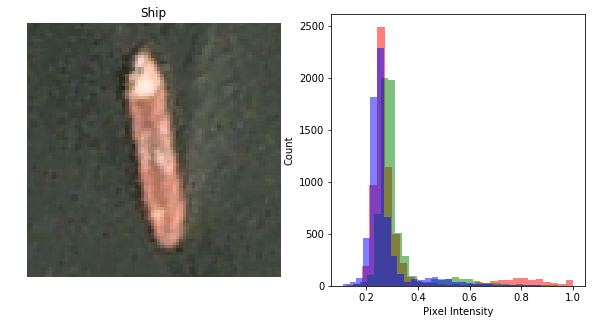

In [8]:
xReshaped = xReshaped/255
plotHistogram(xReshaped[100])

#from sklearn.cross_validation import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2 ,random_state = 123)
# Reduce Sample Size for DeBugging
x_train = x_train[0:300000] 
y_train = y_train[0:300000]
x_test = x_test[0:300000] 
y_test = y_test[0:300000]

x_trainReshaped,x_testReshaped,y_trainReshaped,y_testReshaped = train_test_split(xReshaped,yReshaped,test_size = 0.2 ,random_state = 123)
# Reduce Sample Size for DeBugging
x_trainReshaped = x_trainReshaped[0:300000] 
y_trainReshaped = y_trainReshaped[0:300000]
x_testReshaped = x_testReshaped[0:300000] 
y_testReshaped = y_testReshaped[0:300000]

In [9]:
len(x_test)

560

In [14]:
x_test[0]

array([125, 131, 109, ...,  57,  64,  65], dtype=uint8)


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

LR: 0.868304 (0.020579)
KNN: 0.916518 (0.014265)


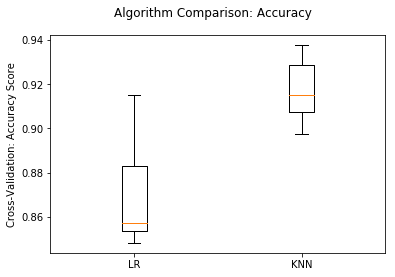

In [11]:
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):   
    print('\nCompare Multiple Classifiers:')
    print('\nK-Fold Cross-Validation Accuracy:\n')
    models = []
    models.append(('LR', LogisticRegression()))
#     models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
#     models.append(('SVM', SVC()))
#     models.append(('LSVM', LinearSVC()))
#     models.append(('GNB', GaussianNB()))
#     models.append(('DTC', DecisionTreeClassifier()))
#     models.append(('XGB', XGBClassifier()))
#    models.append(('GBC', GradientBoostingClassifier()))
#    models.append(('LDA', LinearDiscriminantAnalysis()))  
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a,b)
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        accuracy_results = model_selection.cross_val_score(model, a,b, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)
   
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return

compareABunchOfDifferentModelsAccuracy(x_train,y_train,x_test,y_test)

# def defineModels():
#     print('LR = LogisticRegression')
#     print('RF = RandomForestClassifier')
#     print('KNN = KNeighborsClassifier')
#     print('SVM = Support Vector Machine SVC')
#     print('LSVM = LinearSVC')
#     print('GNB = GaussianNB')
#     print('DTC = DecisionTreeClassifier')
#     print('XGB = XGBClassifier')
# #    print('GBC = GradientBoostingClassifier')
# #    print('LDA = LinearDiscriminantAnalysis')
#     return
# defineModels()

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
